<a href="https://colab.research.google.com/github/zacrenju/DS_Project/blob/master/Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PySpark

What is Pyspark?
PySpark is the Python API for Apache Spark, an open-source, distributed computing framework and set of libraries for real-time, large-scale data processing.

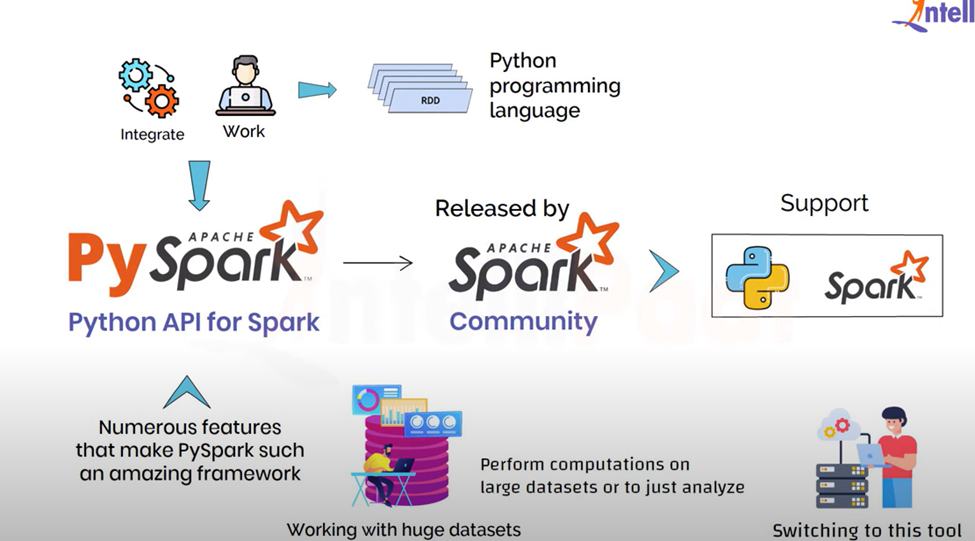


Features of PySpark

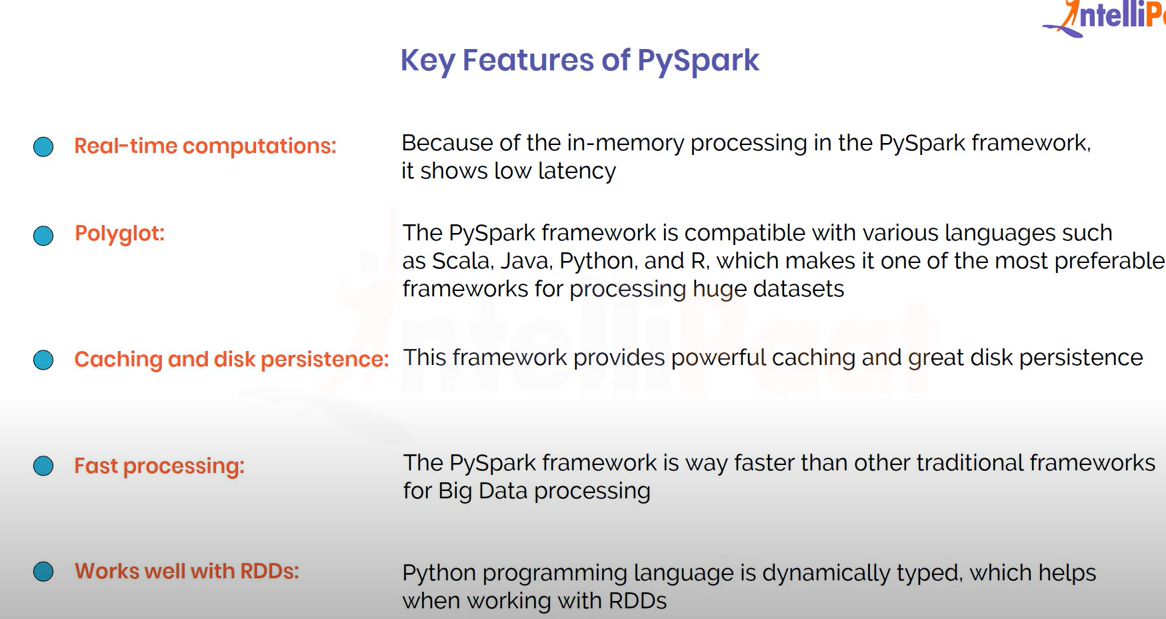

# Configuration

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

# Reading and cleaning of the data

orginal.csv is uploaded to the session

In [2]:
mydata = spark.read.format('csv').option("header","true").load("/content/original.csv")

In [3]:
mydata

DataFrame[id: string, first_name: string, last_name: string, gender: string, City: string, JobTitle: string, Salary: string, Latitude: string, Longitude: string]

In [4]:
mydata.head()

Row(id='1', first_name='Melinde', last_name='Shilburne', gender='Female', City='Nowa Ruda', JobTitle='Assistant Professor', Salary='$57438.18', Latitude='50.5774075', Longitude='16.4967184')

In [5]:
mydata.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|
|  3|    Alvera|  Di Boldi|Female|           null|                null|$57576.52|39.9947462|116.3397725|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.6489954|
|  6|     Maris|      Folk|Female|Kinsealy-Drinan|      Civil Engineer|$30101.16|53.4266145| -6.1644997|
|  7|     Masha|    Divers|Female|         Dachun|     

Cleaning 1: Rename the City which is having null to "Unknown"

1.Create a new Dataframe with new column name CityNew

In [6]:
from pyspark.sql.functions import *

In [7]:
mydataN = mydata.withColumn("CityNew", when(mydata.City.isNull(), "Unknown").otherwise(mydata.City))

In [8]:
mydataN.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|
|  3|    Alvera|  Di Boldi|Female|           null|                null|$57576.52|39.9947462|116.3397725|        Unknown|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|  Divnomorskoye|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.6489954|      Mytishchi|
|  6|     Maris|      Folk|Femal

Step2 : Drop JobTitle which are null

In [9]:
mydataN= mydataN.filter(mydataN.JobTitle.isNotNull())

In [10]:
mydataN.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|  Divnomorskoye|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.6489954|      Mytishchi|
|  6|     Maris|      Folk|Female|Kinsealy-Drinan|      Civil Engineer|$30101.16|53.4266145| -6.1644997|Kinsealy-Drinan|
|  8|   Goddart|     Flear|  Mal

Step 3 : If Salary is missing replace it with avearage

1. Remove $ , then convert the column to float

In [11]:
mydataN = mydataN.withColumn("SalaryNew",mydataN.Salary.substr(2,100).cast("float"))

In [12]:
mean = mydataN.groupBy().avg('SalaryNew')
mean.show()

+-----------------+
|   avg(SalaryNew)|
+-----------------+
|55516.32088199837|
+-----------------+



In [13]:
mean1 = mydataN.groupBy().avg('SalaryNew').take(2)[0][0]
mean1

55516.32088199837

In [14]:
from pyspark.sql.functions import lit
mydataN = mydataN.withColumn("SalaryN", when(mydataN.SalaryNew.isNull(),lit(mean1)).otherwise(mydataN.SalaryNew))

In [15]:
mydataN.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|SalaryNew|         SalaryN|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda| 57438.18|   57438.1796875|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|  62846.6|   62846.6015625|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|  Divnomorskoye| 61489.23|  61489.23046875|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.6489954|      My

Step 4 :  Fill medium value for Latitude if it null

1. Create a new datafram with Latitude

2. remove the null values

3. Find the medium

4. Create new column in orignal dataset for the latitude with Medium

In [16]:
latitude = mydataN.select("Latitude")

In [17]:
latitude = latitude.filter(latitude.Latitude.isNotNull())

In [18]:
latitude.show()

+----------+
|  Latitude|
+----------+
|50.5774075|
|48.8231572|
|44.5047212|
|53.4266145|
|45.1905186|
| 32.027934|
|  4.272793|
|     -5.85|
| 39.172378|
|49.8151822|
|42.1014803|
|49.7923299|
|43.4945737|
|52.7441662|
| 38.696249|
|-7.7232567|
|40.7172049|
|  49.16291|
|40.7576842|
|48.4902808|
+----------+
only showing top 20 rows



In [19]:
latitude = latitude.withColumn("Latitude1", latitude.Latitude.cast("float"))

In [20]:
import numpy as np

In [21]:
latitude

DataFrame[Latitude: string, Latitude1: float]

In [22]:
x = latitude.select(latitude.Latitude1)

In [23]:
lat_med = np.median(latitude.select(latitude.Latitude1).collect())

In [24]:
lat_med

31.93397331237793

In [25]:
mydataN= mydataN.withColumn('lat',when(mydataN.Latitude.isNull(),lit(lat_med)).otherwise(mydataN.Latitude))

In [26]:
mydataN.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|SalaryNew|         SalaryN|              lat|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda| 57438.18|   57438.1796875|       50.5774075|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|  62846.6|   62846.6015625|       48.8231572|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|  Divnomorskoye| 61489.23|  61489.23046875|       44.5047212|
|  5

Q1. Overall whether Men or Women is paid more

Q2. By Job titel Men or Women is paid more

Q3. Which city has the highest salary



In [27]:
import pyspark.sql.functions as sqlfunc

In [28]:
genderAvg =mydataN.groupBy('gender').agg(sqlfunc.avg('SalaryN').alias('AvgSalary'))
genderAvg.show()

+------+------------------+
|gender|         AvgSalary|
+------+------------------+
|Female|55677.250125558036|
|  Male| 55361.09385573019|
+------+------------------+



In [29]:
df_salary= mydataN.withColumn("FemaleSalary",when(mydataN.gender=='Female',mydataN.SalaryN).otherwise(lit(0)))
df_salary= df_salary.withColumn("MaleSalary",when(df_salary.gender=='Male',df_salary.SalaryN).otherwise(lit(0)))


In [30]:
df_salary.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+----------------+----------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|SalaryNew|         SalaryN|              lat|    FemaleSalary|      MaleSalary|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+----------------+----------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda| 57438.18|   57438.1796875|       50.5774075|   57438.1796875|             0.0|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|  62846.6|   62846.6015625|       48.8231572|   62846.6015625|             0.0|


In [31]:
df_salary= df_salary.groupBy('JobTitle').agg(sqlfunc.avg('FemaleSalary').alias("Female_Salary"), sqlfunc.avg('MaleSalary').alias("Male_Salary"))

In [32]:
df_salary.show()

+--------------------+------------------+------------------+
|            JobTitle|     Female_Salary|       Male_Salary|
+--------------------+------------------+------------------+
|Systems Administr...|   50590.474609375|  15540.9501953125|
|   Media Manager III|29586.436197916668|17381.920572916668|
|  Recruiting Manager|34848.452473958336|  26383.4951171875|
|       Geologist III|      31749.046875|    12830.75390625|
|        Geologist II|               0.0|   43293.865234375|
|Database Administ...|               0.0|     52018.4609375|
|   Financial Analyst|   23353.776953125|       39606.05625|
|  Analyst Programmer|  16406.1287109375|  21042.9634765625|
|Software Engineer II|               0.0|      74782.640625|
|       Accountant IV|   82732.248046875|               0.0|
|    Product Engineer|    41825.48359375|       20464.94375|
|Software Test Eng...|  32218.6083984375|   27122.462890625|
|Safety Technician...|               0.0|   29421.529296875|
|    Junior Executive|15

In [33]:
df_salary = df_salary.withColumn('Delta', df_salary.Female_Salary- df_salary.Male_Salary)

In [34]:
df_salary.show()

+--------------------+------------------+------------------+-------------------+
|            JobTitle|     Female_Salary|       Male_Salary|              Delta|
+--------------------+------------------+------------------+-------------------+
|Systems Administr...|   50590.474609375|  15540.9501953125|   35049.5244140625|
|   Media Manager III|29586.436197916668|17381.920572916668|       12204.515625|
|  Recruiting Manager|34848.452473958336|  26383.4951171875|  8464.957356770836|
|       Geologist III|      31749.046875|    12830.75390625|     18918.29296875|
|        Geologist II|               0.0|   43293.865234375|   -43293.865234375|
|Database Administ...|               0.0|     52018.4609375|     -52018.4609375|
|   Financial Analyst|   23353.776953125|       39606.05625|   -16252.279296875|
|  Analyst Programmer|  16406.1287109375|  21042.9634765625| -4636.834765625001|
|Software Engineer II|               0.0|      74782.640625|      -74782.640625|
|       Accountant IV|   827

In [35]:
df_cityavg = mydataN.groupBy("City").agg(sqlfunc.avg('SalaryN').alias('City_Avg_Salary'))

In [36]:
df_cityavg.show()

+-----------------+----------------+
|             City| City_Avg_Salary|
+-----------------+----------------+
|        Sułkowice|  33432.98828125|
|          Klippan|     77039.46875|
|      Trollhättan|53311.6845703125|
|        Shinaihai|    39544.640625|
|         Hongzhou|  35707.30859375|
|         Cipinang| 11617.509765625|
| Viejo Daan Banua|         43927.5|
|         Tsiatsan| 18795.439453125|
|       San Andres|  52426.80078125|
|           Krasna|   72022.7890625|
|      Springfield|40697.3251953125|
|            Město|  27797.98046875|
|Chaloem Phra Kiat|  54840.19921875|
|          Tadotsu|  55595.30078125|
|   Hénin-Beaumont|        55082.75|
|          Kajaani|  20224.83984375|
|           Duozhu|    71416.859375|
|           Abéché|   93375.1796875|
|     Habingkloang|     56892.96875|
|         Malishka|   76783.4765625|
+-----------------+----------------+
only showing top 20 rows



In [37]:
df_cityavg = df_cityavg.sort(col('City_Avg_Salary').desc())

In [38]:
df_cityavg.show()

+-----------------+---------------+
|             City|City_Avg_Salary|
+-----------------+---------------+
|        Mesopotam|    99948.28125|
|       Zhongcheng|   99942.921875|
|           Caxias|  99786.3984375|
|      Karangtawar|  99638.9921875|
|        Itabaiana|    99502.15625|
|           Pasian|    99421.34375|
|           Webuye|   99368.546875|
|      Yuktae-dong|   99250.828125|
|           Zinder|    99222.84375|
|   Timiryazevskiy|     99142.9375|
|        Sawahbaru|  99013.7109375|
|          Madimba|  98737.8671875|
|         Huangshi|    98690.34375|
|          Gharyan|     98679.3125|
|         Yŏnan-ŭp|   98628.609375|
|     Wringinputih|  98603.8203125|
|Monte da Boavista|    98586.71875|
|          Klukeng|  98439.4921875|
|         Murmashi|    98226.15625|
|        Fox Creek|        98138.0|
+-----------------+---------------+
only showing top 20 rows



#CoreConcepts

In [39]:
df = spark.read.csv('original.csv',header=True)

In [40]:
df.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|
|  3|    Alvera|  Di Boldi|Female|           null|                null|$57576.52|39.9947462|116.3397725|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.6489954|
|  6|     Maris|      Folk|Female|Kinsealy-Drinan|      Civil Engineer|$30101.16|53.4266145| -6.1644997|
|  7|     Masha|    Divers|Female|         Dachun|     

In [41]:
df.dtypes

[('id', 'string'),
 ('first_name', 'string'),
 ('last_name', 'string'),
 ('gender', 'string'),
 ('City', 'string'),
 ('JobTitle', 'string'),
 ('Salary', 'string'),
 ('Latitude', 'string'),
 ('Longitude', 'string')]

In [42]:
from pyspark.sql.types import *
schema = StructType([
StructField('id', IntegerType()),
StructField('first_name', StringType()),
 StructField('last_name', StringType()),
 StructField('gender', StringType()),
 StructField('City', StringType()),
 StructField('JobTitle', StringType()),
 StructField('Salary', StringType()),
 StructField('Latitude', StringType()),
 StructField('Longitude', FloatType())
])

In [43]:
df1 = spark.read.csv('original.csv',header=True,schema=schema)

In [44]:
df1.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude| Longitude|
+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.496717|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572| 103.52182|
|  3|    Alvera|  Di Boldi|Female|           null|                null|$57576.52|39.9947462|116.339775|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.130016|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.648994|
|  6|     Maris|      Folk|Female|Kinsealy-Drinan|      Civil Engineer|$30101.16|53.4266145|-6.1644998|
|  7|     Masha|    Divers|Female|         Dachun|              

In [45]:
df1.dtypes

[('id', 'int'),
 ('first_name', 'string'),
 ('last_name', 'string'),
 ('gender', 'string'),
 ('City', 'string'),
 ('JobTitle', 'string'),
 ('Salary', 'string'),
 ('Latitude', 'string'),
 ('Longitude', 'float')]

In [46]:
schemaV1 = StructType([
StructField('id', IntegerType()),
StructField('first_name', StringType()),
 StructField('last_name', StringType()),
 StructField('gender', StringType()),
 StructField('City', StringType()),
 StructField('JobTitle', StringType()),
 StructField('Salary', StringType()),
 StructField('Latitude', FloatType()),
 StructField('Longitude', FloatType())
])

In [47]:
df2 = spark.read.csv('original.csv',header=True,schema=schemaV1)

In [48]:
df2.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude| Longitude|
+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18| 50.577408| 16.496717|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|  48.82316| 103.52182|
|  3|    Alvera|  Di Boldi|Female|           null|                null|$57576.52| 39.994747|116.339775|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23| 44.504723| 38.130016|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.648994|
|  6|     Maris|      Folk|Female|Kinsealy-Drinan|      Civil Engineer|$30101.16| 53.426613|-6.1644998|
|  7|     Masha|    Divers|Female|         Dachun|              

In [49]:
df2.head()

Row(id=1, first_name='Melinde', last_name='Shilburne', gender='Female', City='Nowa Ruda', JobTitle='Assistant Professor', Salary='$57438.18', Latitude=50.57740783691406, Longitude=16.49671745300293)

In [50]:
df2.describe().show()

+-------+-----------------+----------+---------+------+-------------------+-------------------+---------+------------------+-----------------+
|summary|               id|first_name|last_name|gender|               City|           JobTitle|   Salary|          Latitude|        Longitude|
+-------+-----------------+----------+---------+------+-------------------+-------------------+---------+------------------+-----------------+
|  count|             1000|      1000|     1000|  1000|                999|                998|     1000|               999|             1000|
|   mean|            500.5|      null|     null|  null|               null|               null|     null| 25.43151724702484|43.33756460386515|
| stddev|288.8194360957494|      null|     null|  null|               null|               null|     null|24.579082550156635| 69.4206453674681|
|    min|                1|   Abagail|    Abbay|Female|             Abéché|Account Coordinator|$10101.92|         -54.28115|       -123.04196|

In [51]:
df2.first()

Row(id=1, first_name='Melinde', last_name='Shilburne', gender='Female', City='Nowa Ruda', JobTitle='Assistant Professor', Salary='$57438.18', Latitude=50.57740783691406, Longitude=16.49671745300293)

In [52]:
df2.columns

['id',
 'first_name',
 'last_name',
 'gender',
 'City',
 'JobTitle',
 'Salary',
 'Latitude',
 'Longitude']

In [53]:
df2.count()

1000

In [54]:
df2.distinct().count()

1000

In [55]:
df2.distinct().head()

Row(id=372, first_name='Lyman', last_name='Burfitt', gender='Male', City='Guiping', JobTitle='Community Outreach Specialist', Salary='$28755.53', Latitude=23.394325256347656, Longitude=110.07937622070312)

In [56]:
df_dropped = df2.na.drop()

In [57]:
df_dropped.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude| Longitude|
+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18| 50.577408| 16.496717|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|  48.82316| 103.52182|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23| 44.504723| 38.130016|
|  6|     Maris|      Folk|Female|Kinsealy-Drinan|      Civil Engineer|$30101.16| 53.426613|-6.1644998|
|  8|   Goddart|     Flear|  Male|      Trélissac|Desktop Support T...|$46116.36| 45.190517| 0.7423124|
|  9|      Roth|O'Cannavan|  Male|         Heitan|VP Product Manage...|$73697.10| 32.027935| 106.65711|
| 10|      Bran|   Trahear|  Male|       Arbeláez|Mechanical Sys

In [58]:
df_dropped.count()

997

In [59]:
df_null_job= df.filter(df.JobTitle.isNull())

In [60]:
df_null_job.show()

+---+----------+---------+------+------+--------+---------+----------+-----------+
| id|first_name|last_name|gender|  City|JobTitle|   Salary|  Latitude|  Longitude|
+---+----------+---------+------+------+--------+---------+----------+-----------+
|  3|    Alvera| Di Boldi|Female|  null|    null|$57576.52|39.9947462|116.3397725|
|  7|     Masha|   Divers|Female|Dachun|    null|$25090.87| 24.879416| 118.930111|
+---+----------+---------+------+------+--------+---------+----------+-----------+



In [61]:
df_no_duplicates = df2.dropna()

In [62]:
df_no_duplicates.count()

997

In [63]:
df_no_duplicates1 = df2.dropDuplicates()

In [64]:
df_no_duplicates1.count()

1000

In [65]:
df_select_name = df.select( "first_name","last_name")

In [66]:
df_select_name.show()

+----------+----------+
|first_name| last_name|
+----------+----------+
|   Melinde| Shilburne|
|  Kimberly|Von Welden|
|    Alvera|  Di Boldi|
|   Shannon| O'Griffin|
|  Sherwood|   Macieja|
|     Maris|      Folk|
|     Masha|    Divers|
|   Goddart|     Flear|
|      Roth|O'Cannavan|
|      Bran|   Trahear|
|    Kylynn|   Lockart|
|       Rey|    Meharg|
|      Kerr|    Braden|
|    Mickie| Whanstall|
|    Kaspar|     Pally|
|    Norbie|    Gwyllt|
|    Claude|    Briant|
|     Thain|    Habbon|
|  Tiffanie|  Pattison|
|    Ettore|  Gerriets|
+----------+----------+
only showing top 20 rows



In [67]:
df_select_name = df_select_name.withColumnRenamed("first_name",'fn')

In [68]:
df_select_name.show()

+--------+----------+
|      fn| last_name|
+--------+----------+
| Melinde| Shilburne|
|Kimberly|Von Welden|
|  Alvera|  Di Boldi|
| Shannon| O'Griffin|
|Sherwood|   Macieja|
|   Maris|      Folk|
|   Masha|    Divers|
| Goddart|     Flear|
|    Roth|O'Cannavan|
|    Bran|   Trahear|
|  Kylynn|   Lockart|
|     Rey|    Meharg|
|    Kerr|    Braden|
|  Mickie| Whanstall|
|  Kaspar|     Pally|
|  Norbie|    Gwyllt|
|  Claude|    Briant|
|   Thain|    Habbon|
|Tiffanie|  Pattison|
|  Ettore|  Gerriets|
+--------+----------+
only showing top 20 rows



In [69]:
df_filter_name= df_select_name.filter(df_select_name.fn=='Masha')

In [70]:
df_filter_name.show()

+-----+---------+
|   fn|last_name|
+-----+---------+
|Masha|   Divers|
+-----+---------+



In [71]:
df_filter_name = df_select_name.filter(df_select_name.fn.like('Ma%'))

In [72]:
df_filter_name.show()

+---------+-----------+
|       fn|  last_name|
+---------+-----------+
|    Maris|       Folk|
|    Masha|     Divers|
|Marmaduke|      Eykel|
|    Maddy|   Francino|
|Margarete|Andreopolos|
|    Marni|      Loney|
|   Marcus|      Hulls|
|    Manya|    Westall|
|   Marita|    Whyborn|
|      Mab|    Faughny|
| Maurizio| Raddenbury|
|   Mannie|    Lydiate|
| Maryjane|   McKibben|
|     Maxy|    Stonham|
|   Matteo|    Le Teve|
| Maureene|    Prebble|
|   Marlie|     Angelo|
|  Marilin|      Bride|
|    Mandi|     Olivie|
|Marcellus|Northgraves|
+---------+-----------+
only showing top 20 rows



In [73]:
df_filter_name = df_select_name.filter(df_select_name.fn.endswith('m'))
df_filter_name.show()

+-------+---------+
|     fn|last_name|
+-------+---------+
|   Adam|  Seagood|
| Miriam|    Jertz|
|    Rem|Dumberell|
|    Tam|    Elgey|
|  Avram|   Extill|
|     Em|    Matej|
|   Gram|   Jaeggi|
|Hasheem|    Scare|
+-------+---------+



In [74]:
df_filter_name = df_select_name.filter(df_select_name.fn.endswith('m'))
df_filter_name.show()

+-------+---------+
|     fn|last_name|
+-------+---------+
|   Adam|  Seagood|
| Miriam|    Jertz|
|    Rem|Dumberell|
|    Tam|    Elgey|
|  Avram|   Extill|
|     Em|    Matej|
|   Gram|   Jaeggi|
|Hasheem|    Scare|
+-------+---------+



In [75]:
df_filter_name = df_select_name.filter(df_select_name.fn.startswith('M'))
df_filter_name.show()

+---------+-----------+
|       fn|  last_name|
+---------+-----------+
|  Melinde|  Shilburne|
|    Maris|       Folk|
|    Masha|     Divers|
|   Mickie|  Whanstall|
|Marmaduke|      Eykel|
|    Maddy|   Francino|
|    Milka|   Brightie|
|Margarete|Andreopolos|
|   Miriam|      Jertz|
|    Marni|      Loney|
|   Marcus|      Hulls|
|   Monica|    Linfoot|
|    Manya|    Westall|
|   Mikkel|     Hewins|
|   Marita|    Whyborn|
|      Mab|    Faughny|
|    Merle|        Ren|
|   Mischa| Komorowski|
| Maurizio| Raddenbury|
|   Mannie|    Lydiate|
+---------+-----------+
only showing top 20 rows



In [76]:
df_filter_name = df_select_name.filter(df_select_name.fn.isin('Mab','%am'))
df_filter_name.show()

+---+---------+
| fn|last_name|
+---+---------+
|Mab|  Faughny|
+---+---------+



In [77]:
df_substr_name = df_select_name.select(df_select_name.fn, df_select_name.fn.substr(1,5).alias('Nickname'))
df_substr_name .show()

+--------+--------+
|      fn|Nickname|
+--------+--------+
| Melinde|   Melin|
|Kimberly|   Kimbe|
|  Alvera|   Alver|
| Shannon|   Shann|
|Sherwood|   Sherw|
|   Maris|   Maris|
|   Masha|   Masha|
| Goddart|   Godda|
|    Roth|    Roth|
|    Bran|    Bran|
|  Kylynn|   Kylyn|
|     Rey|     Rey|
|    Kerr|    Kerr|
|  Mickie|   Micki|
|  Kaspar|   Kaspa|
|  Norbie|   Norbi|
|  Claude|   Claud|
|   Thain|   Thain|
|Tiffanie|   Tiffa|
|  Ettore|   Ettor|
+--------+--------+
only showing top 20 rows



In [78]:
df_filter_id = df.filter(df.id.between(1,5))
df_filter_id.show()

+---+----------+----------+------+-------------+--------------------+---------+----------+-----------+
| id|first_name| last_name|gender|         City|            JobTitle|   Salary|  Latitude|  Longitude|
+---+----------+----------+------+-------------+--------------------+---------+----------+-----------+
|  1|   Melinde| Shilburne|Female|    Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|
|  2|  Kimberly|Von Welden|Female|       Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|
|  3|    Alvera|  Di Boldi|Female|         null|                null|$57576.52|39.9947462|116.3397725|
|  4|   Shannon| O'Griffin|  Male|Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|
|  5|  Sherwood|   Macieja|  Male|    Mytishchi|            VP Sales|$63863.09|      null| 37.6489954|
+---+----------+----------+------+-------------+--------------------+---------+----------+-----------+



## Multifilters

In [82]:
df_filters = df.filter((df.id.between(1,20)) & (df.id.between(10,100)))
df_filters.show()

+---+----------+---------+------+--------------+--------------------+---------+----------+-----------+
| id|first_name|last_name|gender|          City|            JobTitle|   Salary|  Latitude|  Longitude|
+---+----------+---------+------+--------------+--------------------+---------+----------+-----------+
| 10|      Bran|  Trahear|  Male|      Arbeláez|Mechanical System...|$68098.42|  4.272793| -74.416014|
| 11|    Kylynn|  Lockart|Female|      El Cardo|Nuclear Power Eng...|$13604.63|     -5.85|-79.8833329|
| 12|       Rey|   Meharg|Female|   Wangqingtuo|Systems Administr...|$73423.70| 39.172378| 116.931607|
| 13|      Kerr|   Braden|  Male|     Sułkowice|Compensation Analyst|$33432.99|49.8151822| 19.3771749|
| 14|    Mickie|Whanstall|  Male|   Springfield|Assistant Media P...|$50838.53|42.1014803|-72.5766759|
| 15|    Kaspar|    Pally|  Male|        Chrást|  Analyst Programmer|$40163.03|49.7923299| 13.4915324|
| 16|    Norbie|   Gwyllt|  Male|        Xijiao|              Editor|$324

In [83]:
df_filters = df.filter((df.first_name.startswith('M')) & (df.gender.like('Female')))
df_filters.show()

+---+----------+-----------+------+-----------------+--------------------+---------+----------+-----------+
| id|first_name|  last_name|gender|             City|            JobTitle|   Salary|  Latitude|  Longitude|
+---+----------+-----------+------+-----------------+--------------------+---------+----------+-----------+
|  1|   Melinde|  Shilburne|Female|        Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|
|  6|     Maris|       Folk|Female|  Kinsealy-Drinan|      Civil Engineer|$30101.16|53.4266145| -6.1644997|
|  7|     Masha|     Divers|Female|           Dachun|                null|$25090.87| 24.879416| 118.930111|
| 94|     Milka|   Brightie|Female|            Kítsi|Occupational Ther...|$31388.07|37.8519345| 23.8408158|
| 99| Margarete|Andreopolos|Female|        Neglasari|    Quality Engineer|$23216.03| -6.147133|106.6232359|
|108|    Miriam|      Jertz|Female|            Hekou|    Quality Engineer|$27902.32| 22.529403|  103.93935|
|116|     Marni|      Loney|

In [84]:
df_filters = df.filter((df.first_name.startswith('M')) | (df.gender.like('Female')))
df_filters.show()

+---+----------+----------+------+----------------+--------------------+---------+----------+-----------+
| id|first_name| last_name|gender|            City|            JobTitle|   Salary|  Latitude|  Longitude|
+---+----------+----------+------+----------------+--------------------+---------+----------+-----------+
|  1|   Melinde| Shilburne|Female|       Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|
|  2|  Kimberly|Von Welden|Female|          Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|
|  3|    Alvera|  Di Boldi|Female|            null|                null|$57576.52|39.9947462|116.3397725|
|  6|     Maris|      Folk|Female| Kinsealy-Drinan|      Civil Engineer|$30101.16|53.4266145| -6.1644997|
|  7|     Masha|    Divers|Female|          Dachun|                null|$25090.87| 24.879416| 118.930111|
| 11|    Kylynn|   Lockart|Female|        El Cardo|Nuclear Power Eng...|$13604.63|     -5.85|-79.8833329|
| 12|       Rey|    Meharg|Female|     Wangqin

#Running SQL on Dataframes

In [87]:
df2.registerTempTable("Original")

In [88]:
df2.dtypes

[('id', 'int'),
 ('first_name', 'string'),
 ('last_name', 'string'),
 ('gender', 'string'),
 ('City', 'string'),
 ('JobTitle', 'string'),
 ('Salary', 'string'),
 ('Latitude', 'float'),
 ('Longitude', 'float')]

In [90]:
sqlquery1=spark.sql("Select * from Original")
sqlquery1.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude| Longitude|
+---+----------+----------+------+---------------+--------------------+---------+----------+----------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18| 50.577408| 16.496717|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|  48.82316| 103.52182|
|  3|    Alvera|  Di Boldi|Female|           null|                null|$57576.52| 39.994747|116.339775|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23| 44.504723| 38.130016|
|  5|  Sherwood|   Macieja|  Male|      Mytishchi|            VP Sales|$63863.09|      null| 37.648994|
|  6|     Maris|      Folk|Female|Kinsealy-Drinan|      Civil Engineer|$30101.16| 53.426613|-6.1644998|
|  7|     Masha|    Divers|Female|         Dachun|              

In [91]:
sqlquery1

DataFrame[id: int, first_name: string, last_name: string, gender: string, City: string, JobTitle: string, Salary: string, Latitude: float, Longitude: float]

In [93]:
sqlquery2=spark.sql("Select concat(first_name, ' ', last_name) as Full_name from Original where gender=='Female'")
sqlquery2.show()

+-------------------+
|          Full_name|
+-------------------+
|  Melinde Shilburne|
|Kimberly Von Welden|
|    Alvera Di Boldi|
|         Maris Folk|
|       Masha Divers|
|     Kylynn Lockart|
|         Rey Meharg|
|      Claude Briant|
|  Tiffanie Pattison|
|    Lurleen Janczak|
|      Nichol Holtum|
|       Shaun Bridle|
|     Leandra Anfrey|
|    Jaquelyn Hazard|
|  Prudence Honacker|
|       Cherey Liger|
|          Neda Krop|
|    Barbi Fattorini|
|   Lonnie Townshend|
|    Valida Salzberg|
+-------------------+
only showing top 20 rows



In [94]:
mydataN.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|SalaryNew|         SalaryN|              lat|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda| 57438.18|   57438.1796875|       50.5774075|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|  62846.6|   62846.6015625|       48.8231572|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171|  Divnomorskoye| 61489.23|  61489.23046875|       44.5047212|
|  5

In [95]:
mydataN.dtypes

[('id', 'string'),
 ('first_name', 'string'),
 ('last_name', 'string'),
 ('gender', 'string'),
 ('City', 'string'),
 ('JobTitle', 'string'),
 ('Salary', 'string'),
 ('Latitude', 'string'),
 ('Longitude', 'string'),
 ('CityNew', 'string'),
 ('SalaryNew', 'float'),
 ('SalaryN', 'double'),
 ('lat', 'string')]

In [97]:
df_salary_n = mydataN.withColumn('MonthlySalary',mydataN.SalaryN/12)
df_salary_n.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+------------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|SalaryNew|         SalaryN|              lat|     MonthlySalary|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+------------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda| 57438.18|   57438.1796875|       50.5774075| 4786.514973958333|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|  62846.6|   62846.6015625|       48.8231572|    5237.216796875|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$614

## WIll check if the who all are above the average salary

In [98]:
dfSalaryAverage= mydataN.withColumn("AboveAverage",when(mydataN.SalaryN > lit(mean1), 'True').otherwise("False"))

In [99]:
dfSalaryAverage.show()

+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+------------+
| id|first_name| last_name|gender|           City|            JobTitle|   Salary|  Latitude|  Longitude|        CityNew|SalaryNew|         SalaryN|              lat|AboveAverage|
+---+----------+----------+------+---------------+--------------------+---------+----------+-----------+---------------+---------+----------------+-----------------+------------+
|  1|   Melinde| Shilburne|Female|      Nowa Ruda| Assistant Professor|$57438.18|50.5774075| 16.4967184|      Nowa Ruda| 57438.18|   57438.1796875|       50.5774075|        True|
|  2|  Kimberly|Von Welden|Female|         Bulgan|       Programmer II|$62846.60|48.8231572|103.5218199|         Bulgan|  62846.6|   62846.6015625|       48.8231572|        True|
|  4|   Shannon| O'Griffin|  Male|  Divnomorskoye|Budget/Accounting...|$61489.23|44.5047212| 38.1300171| 

In [101]:
dfAverage = mydataN.groupBy('gender').agg(sqlfunc.sum('SalaryNew'))
dfAverage.show()

+------+--------------------+
|gender|      sum(SalaryNew)|
+------+--------------------+
|Female|2.7281852561523438E7|
|  Male|2.8123435678710938E7|
+------+--------------------+



In [102]:
dfAverage = mydataN.groupBy('gender').agg(sqlfunc.sum('SalaryNew').alias("Sum"),
                                           sqlfunc.avg('SalaryNew').alias("Avg"),
                                            sqlfunc.max('SalaryNew').alias("Max"),
                                             sqlfunc.min('SalaryNew').alias("Min"))

dfAverage.show()

+------+--------------------+------------------+--------+--------+
|gender|                 Sum|               Avg|     Max|     Min|
+------+--------------------+------------------+--------+--------+
|Female|2.7281852561523438E7|55677.250125558036|99948.28|10616.44|
|  Male|2.8123435678710938E7| 55361.09385573019|99942.92|10101.92|
+------+--------------------+------------------+--------+--------+



In [103]:
dfAverageGC = mydataN.groupBy('gender','City').agg(sqlfunc.sum('SalaryNew').alias("Sum"),
                                           sqlfunc.avg('SalaryNew').alias("Avg"),
                                            sqlfunc.max('SalaryNew').alias("Max"),
                                             sqlfunc.min('SalaryNew').alias("Min"))

dfAverageGC.show()

+------+-----------------+----------------+----------------+--------+--------+
|gender|             City|             Sum|             Avg|     Max|     Min|
+------+-----------------+----------------+----------------+--------+--------+
|Female|      Trollhättan|106623.369140625|53311.6845703125| 79792.9|26830.47|
|  Male|          Wenshao| 18941.509765625| 18941.509765625|18941.51|18941.51|
|Female|            Lanas| 13765.900390625| 13765.900390625| 13765.9| 13765.9|
|  Male|            Mörön|    77940.078125|    77940.078125|77940.08|77940.08|
|Female|             Same|   73369.7265625|   73369.7265625|73369.73|73369.73|
|Female|          Sawahan|  24608.83984375|  24608.83984375|24608.84|24608.84|
|  Male|Monte da Boavista|     98586.71875|     98586.71875|98586.72|98586.72|
|Female|         Nusajaya|    71637.921875|    71637.921875|71637.92|71637.92|
|Female|            Kista|   96192.3984375|   96192.3984375| 96192.4| 96192.4|
|  Male|       Pittsburgh|    83121.890625|    83121

In [104]:
dfAverageGC.write.csv('dfAverageGC.csv')

In [107]:
dfAverageGC.write.json('dfAverageGCN.json')
dfAverageGC.write.parquet('dfAverageGCN.parquet')

##Challenge

In [112]:
challengeSchema = StructType([
StructField('ip_address', StringType()),
StructField('Country', StringType()),
 StructField('Domain Name', StringType()),
 StructField('Bytes_used', IntegerType())
])

In [113]:
dfChallenge = spark.read.csv("/content/challenge.csv",header=True,schema=challengeSchema)

In [114]:
dfChallenge.show()

+---------------+--------------+-----------------+----------+
|     ip_address|       Country|      Domain Name|Bytes_used|
+---------------+--------------+-----------------+----------+
|  52.81.192.172|         China| odnoklassniki.ru|       463|
| 119.239.207.13|         China|         youtu.be|        51|
|  68.69.217.210|         China|        adobe.com|        10|
|   7.191.21.223|      Bulgaria|     linkedin.com|       853|
|   211.13.10.68|     Indonesia|          hud.gov|        29|
|   239.80.21.97|      Suriname|       smh.com.au|       218|
|106.214.106.233|       Jamaica|    amazonaws.com|        95|
| 127.242.24.138|         China| surveymonkey.com|       123|
|     99.2.6.139|Czech Republic|     geocities.jp|       322|
|   237.54.11.63|         China|       amazon.com|        83|
| 252.141.157.25|         Japan|      cornell.edu|       374|
|185.220.128.248|       Belgium|       weebly.com|       389|
|   151.77.19.45|   Afghanistan|independent.co.uk|       282|
|  9.161

In [115]:
dfChallenge.dtypes

[('ip_address', 'string'),
 ('Country', 'string'),
 ('Domain Name', 'string'),
 ('Bytes_used', 'int')]

In [117]:
dfChallenge=dfChallenge.withColumn("Mexico",when( dfChallenge.Country== 'Mexico',"Yes").otherwise("No"))
dfChallenge.show()

+---------------+--------------+-----------------+----------+------+
|     ip_address|       Country|      Domain Name|Bytes_used|Mexico|
+---------------+--------------+-----------------+----------+------+
|  52.81.192.172|         China| odnoklassniki.ru|       463|    No|
| 119.239.207.13|         China|         youtu.be|        51|    No|
|  68.69.217.210|         China|        adobe.com|        10|    No|
|   7.191.21.223|      Bulgaria|     linkedin.com|       853|    No|
|   211.13.10.68|     Indonesia|          hud.gov|        29|    No|
|   239.80.21.97|      Suriname|       smh.com.au|       218|    No|
|106.214.106.233|       Jamaica|    amazonaws.com|        95|    No|
| 127.242.24.138|         China| surveymonkey.com|       123|    No|
|     99.2.6.139|Czech Republic|     geocities.jp|       322|    No|
|   237.54.11.63|         China|       amazon.com|        83|    No|
| 252.141.157.25|         Japan|      cornell.edu|       374|    No|
|185.220.128.248|       Belgium|  

In [118]:
dfAverage = dfChallenge.groupBy('Mexico').agg(sqlfunc.sum('Bytes_used'))
dfAverage.show()

+------+---------------+
|Mexico|sum(Bytes_used)|
+------+---------------+
|    No|         508076|
|   Yes|           6293|
+------+---------------+



In [121]:
dfCount = dfChallenge.groupBy('Country').agg(sqlfunc.countDistinct('ip_address'))
dfCount.show(50)

+--------------------+-----------------+
|             Country|count(ip_address)|
+--------------------+-----------------+
|                Chad|                1|
|              Russia|               56|
|            Paraguay|                1|
|               Yemen|                1|
|              Sweden|               28|
|         Philippines|               65|
|            Malaysia|                5|
|              Turkey|                1|
|              Malawi|                2|
|             Germany|                5|
|             Comoros|                1|
|         Afghanistan|                5|
|              Rwanda|                1|
|               Sudan|                1|
|              France|               21|
|              Greece|                8|
|           Sri Lanka|                3|
|            Dominica|                1|
|           Argentina|               14|
|             Belgium|                1|
|             Ecuador|                2|
|             Le